# $d$-separation, causal and noncausal paths

## $d$-separation rules

$d$-separation rules, these rules, when they are used with a causasl Bayesian network can help us to know which variables to include in the statistical analysis and which variables not to include to avoid biases when we are interested in estimating causal effects between variables.

Suppose that we are interested in the causal effect of a variable $X$ in another variable $Y$, but that there exists unobserved variables $U$ that affect both $X$ and $Y$, so the DAG looks like

In [1]:
# The next libraries are to plot DAGs
import collections.abc
collections.Iterable = collections.abc.Iterable
from causalgraphicalmodels import CausalGraphicalModel

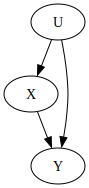

In [2]:
DagConfounded = CausalGraphicalModel(nodes=["X", "Y", "U"], edges=[("X", "Y"), ("U", "X"), ("U", "Y")])
DagConfounded.draw()

In this DAG there are two paths connecting $X$ and $Y$. A causal path given by $X\rightarrow Y$, and a noncausal path given by $X\leftarrow U\rightarrow Y$. This implies that a causal interpretation of a regression analysis between $Y$ and $X$ would be incorrected. In this case, it is usually said that the result is confounded by the variables $U$. We say that a path between $X$ and $Y$ is closed if $X$ is independent of $Y$. A path is causal if all the arrows in the path go in the same direction (from $X$ to $Y$). Thus, to get a reliable causal interpretation we need to close all the non-causal paths, while keeping open the causal ones.

For any DAG, there are three basic relations between the variables, which satisfies certain conditional independencies

1. **Fork**: In a fork some variable $Z$ is a common cause of $X$ and $Y$, $X\leftarrow Z \rightarrow Y$. We saw in the previous chapter that this DAG creates a relation between $X$ and $Y$, but once we include $Z$, this relation desappears. That is $X\not\perp\!\!\!\perp Y$, but $X\perp\!\!\!\perp Y|Z$.

2. **Pipe**: A pipe or a mediation case is when $X$ influences $Y$ through a third variable $Z$, $X\rightarrow Z\rightarrow Y$. As in the fork, this path is open unless we include the variable $Z$, in such case $X$ and $Y$ becomes independent as we observed in the post-treatment bias. That is $X\not\perp\!\!\!\perp Y$, but $X\perp\!\!\!\perp Y|Z$.

3. **Collider** In a collider some variable $Z$ is the consequence of $X$ and $Y$, $X\rightarrow Z\leftarrow Y$. Unlike the other two types of relations, in a collider there is no association between $X$ and $Y$ unless you condition on $Z$, as we commented in the Berkson's paradox. That is That is $X\perp\!\!\!\perp Y$, but $X\not\perp\!\!\!\perp Y|Z$.

Here's the recipe then that would help you to determine which variables to include or exclude from the analysis when the goal is causasl inference.

1. List all the paths connecting $X$ and $Y$.

2. Classify each path by wether it is causal or non-causal.

3. Classify each path by whether it is open or closed. A path is open unless it contains a collider.

4. Determine the variables to condition on, so the causal paths are kept open, and the non-causal paths are closed.

To illustrate these points, in the next table I present the examples analyzed in [Chapter 13](../Part5/13_CategoricalAndBiases)

|        Example        | Cause | Consequence |                Paths            | Causal | Contains colliders | Close/Open | How to Open/Close |
|:---------------------:| :---: |:-----------:|:-------------------------------:| :---:  |:------------------:|:----------:|:--------------------------:|
| Treatment with effect |  $T$  |    $H_1$    | $T\rightarrow F\rightarrow H_1$ |  Yes   |         No         |    Open    | To close: conditioning in $F$ |
| Treatment without effect| $T$ |    $H_1$    | $T\rightarrow F \leftarrow M \rightarrow H_1$ | No | Yes |        Close    | To open: conditioning in $F$  |
| Beauty and talent | $B$ | $T$ | $B\rightarrow S\leftarrow T$ | No | Yes | Close | To open: conditioning in $S$ |
| Shoes and reading | $S$ | $R$ | $S\leftarrow A\rightarrow R$ | No | No | Open | To close: conditioning in $A$ |

## The haunted DAG

```{note}
This example was taken from {cite}`mcelreath2018statistical`.
```

Unmeasured causes can still induce biases. So we also have to consider the possibility that our DAG may be haunted.

Suppose for example that we want to infer the influence of grandparents ($G$) on the educational achievement of children ($C$). Assume that there is a direct effect of grandparents in the education of the children and a mediation relation trough their parents ($P$). But suppose there are unmeasured, common influences on parents and their children, $U$, such as neighborhoods, that are not shared by grandparents.

In [3]:
from scipy.stats import norm, bernoulli

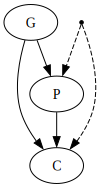

In [4]:
DagChildrenEducation = CausalGraphicalModel(nodes=["G", "P", "C"], edges=[("G", "P"), ("P", "C"), ("G", "C")], latent_edges=[("P", "C")])
DagChildrenEducation.draw()

In the next table I present the the analysis of the paths connecting $G$ and $C$.

| Example | Cause | Consequence |                Paths            | Causal | Contains colliders | Close/Open | How to Open/Close |
|:-------:| :---: |:-----------:|:-------------------------------:| :---:  |:------------------:|:----------:|:-----------------:|
| Haunted DAG | $G$ | $C$ | $G\rightarrow C$ | Yes | No | Open | |
| | | | $G\rightarrow P\rightarrow C$ | Yes | No | Open | To close: conditioning in $P$ |
| | | | $G\rightarrow P\leftarrow U\rightarrow C$ | No | Yes | Close | To open: conditioning in $P$ |

Now $P$ is a common consecuence between $G$ and $U$. Thus, conditioning in $P$ would create a bias between $G$ and $C$.

Let's make a simulation study for this DAG. The code with all the details is [23HauntedDag.ipynb](https://github.com/IrvingGomez/BayesianStatistics/blob/main/Codes/23HauntedDag.ipynb) in the [repository of the course](https://github.com/IrvingGomez/BayesianStatistics)

In [5]:
ALPHA_LEVEL = 0.11

N = 4000

b_GC = 0.75
b_GP = 1.5
b_PC = 1.5
b_U  = 2

U = bernoulli.rvs(size=N, p=0.5)*2 -1
G = norm.rvs(size=N)
P = norm.rvs(size=N, loc=b_GP*G + b_U*U)
C = norm.rvs(size=N, loc=b_PC*P + b_GC*G + b_U*U)

The next figure shows teh DAG of the data, the numbers on the arrows indicate the value of the coefficients. We expect the total effect of $G$ into $C$ to be around $1.5\times 1.5 + 0.75 = 3$

```{image} Images/DagHaunted.png
:alt: DagHaunted
:align: center
```

The next figure shows the result when we regressed $C$ in function of $G$ without conditioning in $P$ nor $U$, where we can observe the total effect of $G$ into $C$.

| Parameter | Posterior mean | Credible interval (89%) |
| :------- | :-------: | :-----------: |
| $\beta_{GC}$ | 3.054 | (2.921, 3.191) |

```{image} Images/HauntedGInC.png
:alt: HauntedGInC
:align: center
```

If we were able measure $U$, we would be able to get the total effect of $G$ into $C$ even conditioning in $U$. This is because the non-causal path $G\rightarrow P \leftarrow U \rightarrow C$ is closed because $P$ is a collider.

| Parameter | Posterior mean | Credible interval (89%) |
| :------- | :-------: | :-----------: |
| $\beta_{GC}\vert U=1$ | 3.036 | (2.968, 3.098) |
| $\beta_{GC}\vert U=-1$ | 3.005 | (2.940, 3.069) |

```{image} Images/HauntedGInCAdjustU.png
:alt: HauntedGInCAdjustU
:align: center
```

We could naively think that including $P$ (remember that $U$ is unmeasured) would help us to estimate the direct effect of $G$ into $C$. But, when we controlled by $P$ the problems arrive! 

| Parameter | Posterior mean | Credible interval (89%) |
| :------- | :-------: | :-----------: |
| $\beta_{PC}$ | 2.301 | (2.285, 2.315) |
| $\beta_{GC}$ | **-0.446** | **(-0.487, -0.407)** |

2.301	0.009	2.285	2.315
Beta_GC	-0.446	0.025	-0.487	-0.407

**We now observe that the apparent effect of $G$ in $C$ is now negative!** This is known as the Simpson's Paradox. To show this bizarre behavior, in the next graph I present the regression considering only the observations whose value of $P$ is between the 0.45 and 0.6
quantiles.

```{image} Images/HauntedGInCAdjustP.png
:alt: HauntedGInCAdjustP
:align: center
```

In this case, the only way to estimate the direct effects of $G$ and $P$ into $C$ is if we adjust by $P$ and $C$.

| Parameter | Posterior mean | Credible interval (89%) |
| :------- | :-------: | :-----------: |
| $\beta_{PC}\vert U=1$ | 1.461 | (1.424, 1.493) |
| $\beta_{PC}\vert U=-1$ | 1.486 | (1.446, 1.521) |
| $\beta_{GC}\vert U=1$ | 0.803 | (0.741, 0.868) |
| $\beta_{GC}\vert U=-1$ | 0.768 | (0.700, 0.835) |

```{image} Images/HauntedGInCAdjustUAdjustP.png
:alt: HauntedGInCAdjustUAdjustP
:align: center
```

```{seealso}
A pretty nice tool that I have used to analyze causal diagrams is `DAGitty`: [https://www.dagitty.net/](https://www.dagitty.net/). It is implented in `R`, but you can use it online.
```